# PETSc ARG

## Setup

First, check if you are at the correct project environment.

In [ ]:
using Pkg
Pkg.status()

Then check if all packages are installed and up to date:

In [ ]:
Pkg.update()

In [1]:
using ExperimentalDesign, StatsModels, GLM, DataFrames, Distributions, Random, StatsPlots

# Designs with Categorical Factors

In [2]:
design_distribution = DesignDistribution((ksp_type = CategoricalFactor(["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]),
        pc_type = CategoricalFactor(["jacobi", "sor", "bjacobi", "mg"])))

DesignDistribution
Formula: 0 ~ ksp_type + pc_type
Factor Distributions:
ksp_type: CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)

pc_type: CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)


In [3]:
design = rand(design_distribution, 300)
f = @formula 0 ~ ksp_type + pc_type
optimal_design = OptimalDesign(design, f, 10)

OptimalDesign
Dimension: (10, 2)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [217, 226, 236, 250, 263, 247, 277, 81, 70, 77]
Optimality Criteria: Dict(:D => 0.0035495366523496086)
Design Matrix:
10×2 DataFrame
│ Row │ ksp_type │ pc_type │
│     │ String   │ String  │
├─────┼──────────┼─────────┤
│ 1   │ cr       │ jacobi  │
│ 2   │ gcr      │ jacobi  │
│ 3   │ cg       │ jacobi  │
│ 4   │ cr       │ mg      │
│ 5   │ cg       │ bjacobi │
│ 6   │ fcg      │ bjacobi │
│ 7   │ bcgs     │ jacobi  │
│ 8   │ tcqmr    │ sor     │
│ 9   │ cgs      │ sor     │
│ 10  │ gmres    │ sor     │

Plot design

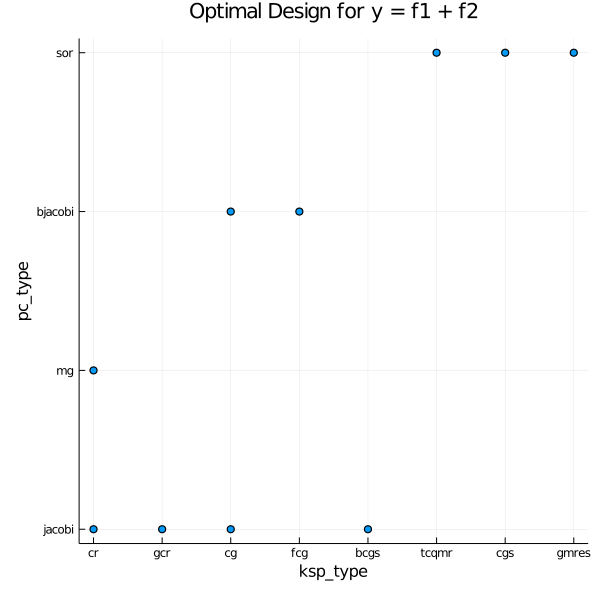

In [4]:
@df optimal_design.matrix scatter(:ksp_type,
    :pc_type,
    size = (600, 600),
    xlabel = "ksp_type",
    ylabel = "pc_type",
    legend = false,
    title = "Optimal Design for y = f1 + f2")

## Target Application Parameters

In [8]:
cmd_prefix = ["singularity", "exec", "--nv", "../container/petsc-gpu.sif", "make", "-C", "../src"]
dev = "core"
np = 4
res = 100

100

## Response Function

In [9]:
# x is a set of flags
function y(x)
    parameters = []
    for i in 1:length(x)
        push!(parameters, rstrip(string(uppercase(string(keys(x)[i])), "=", x[i], " ")))
    end
    
    cmd = `$cmd_prefix $[dev, "NP=$np", "RES=$res"] $parameters`

    exec_time = @elapsed run(cmd)
    return exec_time
end

y (generic function with 1 method)

In [10]:
optimal_design.matrix[!, :response] = y.(eachrow(optimal_design.matrix))

make: Entering directory '/home/luciano/Desktop/petsc-arg/src'
/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type cr -pc_type jacobi -log_view
 Data for JOB [19548,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [19548,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [19548,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [19548,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [19548,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000164949 iterations 157
************************************************************************************************************************
***             WIDEN YOUR WINDOW 


Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -lquadmath -lpthread -lstdc++ -ldl
-----------------------------------------

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Enter


Using include paths: -I/opt/petsc/include -I/opt/petsc/arch-linux2-c-opt/include -I/usr/local/cuda/include
-----------------------------------------

Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Entering directory '/home/luciano/Desktop/petsc-arg/src'
/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type cr -pc_type mg -log_view
 Data for JOB [17227,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [17227,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [17227,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [17227,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [17227,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000826852 iterations 44
**************************************************************************************************

sizeof(short) 2 sizeof(int) 4 sizeof(long) 8 sizeof(void*) 8 sizeof(PetscScalar) 8 sizeof(PetscInt) 4
Configure options: --with-debugging=no --with-openmp=1 --with-cuda=1 --download-superlu_dist --download-mumps --download-hypre --download-scalapack --download-spai --download-parms --download-slepc --download-openmpi=yes --download-openmpi-configure-arguments=--with-cuda=/usr/local/cuda CUDAOPTFLAGS= COPTFLAGS= CXXOPTFLAGS= FOPTFLAGS=
-----------------------------------------
Libraries compiled on 2020-08-02 15:41:14 on petsc-gpu 
Machine characteristics: Linux-5.4.0-42-generic-x86_64-with-debian-10.5
Using PETSc directory: /opt/petsc
Using PETSc arch: arch-linux2-c-opt
-----------------------------------------

Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -W

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Entering directory '/home/luciano/Desktop/petsc-arg/src'
/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type fcg -pc_type bjacobi -log_view
 Data for JOB [17387,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [17387,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [17387,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [17387,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [17387,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000383786 iterations 69
********************************************************************************************


Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -lquadmath -lpthread -lstdc++ -ldl
-----------------------------------------

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Enter


Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -lquadmath -lpthread -lstdc++ -ldl
-----------------------------------------

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Enter


Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -lquadmath -lpthread -lstdc++ -ldl
-----------------------------------------

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Enter

make: Leaving directory '/home/luciano/Desktop/petsc-arg/src'
make: Entering directory '/home/luciano/Desktop/petsc-arg/src'
/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type gmres -pc_type sor -log_view
 Data for JOB [16685,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [16685,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [16685,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [16685,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [16685,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000658113 iterations 119
*********************************************************************************************


Using include paths: -I/opt/petsc/include -I/opt/petsc/arch-linux2-c-opt/include -I/usr/local/cuda/include
-----------------------------------------

Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -

10-element Array{Float64,1}:
 3.238820278
 3.258861884
 3.148857314
 3.247462042
 3.284116902
 3.29207796
 3.115262505
 3.189036541
 3.219284431
 3.116255492

In [11]:
print(optimal_design)

OptimalDesign
Dimension: (10, 3)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [217, 226, 236, 250, 263, 247, 277, 81, 70, 77]
Optimality Criteria: Dict(:D => 0.0035495366523496086)
Design Matrix:
10×3 DataFrame
│ Row │ ksp_type │ pc_type │ response │
│     │ String   │ String  │ Float64  │
├─────┼──────────┼─────────┼──────────┤
│ 1   │ cr       │ jacobi  │ 3.23882  │
│ 2   │ gcr      │ jacobi  │ 3.25886  │
│ 3   │ cg       │ jacobi  │ 3.14886  │
│ 4   │ cr       │ mg      │ 3.24746  │
│ 5   │ cg       │ bjacobi │ 3.28412  │
│ 6   │ fcg      │ bjacobi │ 3.29208  │
│ 7   │ bcgs     │ jacobi  │ 3.11526  │
│ 8   │ tcqmr    │ sor     │ 3.18904  │
│ 9   │ cgs      │ sor     │ 3.21928  │
│ 10  │ gmres    │ s